In [11]:
import numpy as np
from numpy.linalg import matrix_rank, inv
from numpy.linalg import matrix_rank, inv
from pprint import pprint
import matplotlib.pyplot as plt

import sys
import os
current_notebook_dir = os.getcwd()
# Replace with the path to your IT_PI.py function
project_root_dir = os.path.join(current_notebook_dir, '..', '..')
it_pi_module_dir = project_root_dir
sys.path.append(it_pi_module_dir)
import IT_PI

plt.rcParams['font.family'] = 'Times New Roman'  # Set the font to Times New Roman
plt.rcParams['text.usetex'] = True  # Use LaTeX for all text rendering/', VIEW.as_view(), name=''),

In [12]:
# load the Dixit_data.npz file
def load_data(filename):
    data = np.load(filename)
    return data['X'], data['Y'], data['zpg_indices'], data['apg_indices'],data['fpg_indices']

# how to assign the loaded data to variables
X, Y, zpg_indices, apg_indices, fpg_indices = load_data('Dixit_data.npz')

In [13]:
num_input = 1
variables = ['U_{\infty}','\\nu','M','\\delta','\\delta^*','\\theta'];

D_in = np.matrix('1 2 3 1 1 1 ; -1 -1 -2 0 0 0')

print("Rank of D_in:", matrix_rank(D_in))
print("D_in matrix:\n", D_in)
num_rows   = np.shape(D_in)[0]
num_cols   = np.shape(D_in)[1]
num_basis      = D_in.shape[1] -matrix_rank(D_in)
basis_matrices = IT_PI.calc_basis(D_in, num_basis)
print("Basis vectors:")
pprint(basis_matrices)

Rank of D_in: 2
D_in matrix:
 [[ 1  2  3  1  1  1]
 [-1 -1 -2  0  0  0]]
Basis vectors:
matrix([[ 1.,  1., -1.,  0.,  0.,  0.],
        [-1.,  1.,  0., -1.,  0.,  0.],
        [-1.,  1.,  0.,  0., -1.,  0.],
        [-1.,  1.,  0.,  0.,  0., -1.]])


In [14]:
# Run dimensionless learning
results = IT_PI.main(
    X,
    Y.reshape(-1, 1),
    basis_matrices,
    num_input=num_input,
    estimator="kraskov",
    estimator_params={"k": 10},
    seed=666
)


------------------------------------------------------------
num of parameters: 4

Using estimator: 'kraskov' with hyperparameters: {'k': 10}

(150_w,300)-aCMA-ES (mu_w=78.0,w_1=3%) in dimension 4 (seed=666, Sun Sep  7 12:17:47 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1    300 -1.280763825927101e+00 1.0e+00 5.14e-01  4e-01  5e-01 0:00.1
    2    600 -1.456315799419306e+00 3.6e+00 7.06e-01  5e-01  7e-01 0:00.3
    3    900 -1.584873413550447e+00 1.2e+01 1.10e+00  9e-01  1e+00 0:00.4
   26   7800 -1.788824069193560e+00 7.2e+01 5.92e+00  4e-03  2e-02 0:03.5
   44  13200 -1.789202421683981e+00 2.4e+02 1.56e+01  5e-04  2e-03 0:05.7
termination on tolflatfitness=1
final/bestever f-value = -1.789202e+00 -1.789261e+00 after 13200/5537 evaluations
incumbent solution: [-1.00449979, 1.29687451, 1.99420517, -1.99361634]
std deviation: [0.00047651, 0.00052224, 0.00189009, 0.00162323]
Optimized_params: [-1.0018118   1.29029651  1.98434245 -1.98205245]
Optimiz

In [15]:
input_PI = 1/results["input_PI"]
output_PI = results["output_PI"]
epsilon  = results["irreducible_error"]
uq       = results["uncertainty"]
coef_pi_list = results["input_coef"]
print('epsilon = ', epsilon)
output_PI = results["output_PI"]
epsilon,uq = IT_PI.calculate_bound_and_uq(input_PI,output_PI,num_trials= 10)
# I am doning 1/ input_PI, so you should coef_pi_list to minus the sign
coef_pi_list = [-coef for coef in coef_pi_list]
optimal_pi_lab   = IT_PI.create_labels(np.array(coef_pi_list).reshape(-1, len(variables)), variables)
for j, label in enumerate(optimal_pi_lab):
    print(f'Optimal_pi_lab[{j}] = {label}')


epsilon =  [0.21548296184368393]
Optimal_pi_lab[0] = $\frac{U_{\infty}^{1.0} \cdot \delta^{0.56} \cdot \delta^*^{0.86}}{\nu^{0.13} \cdot M^{0.44} \cdot \theta^{0.86}}$


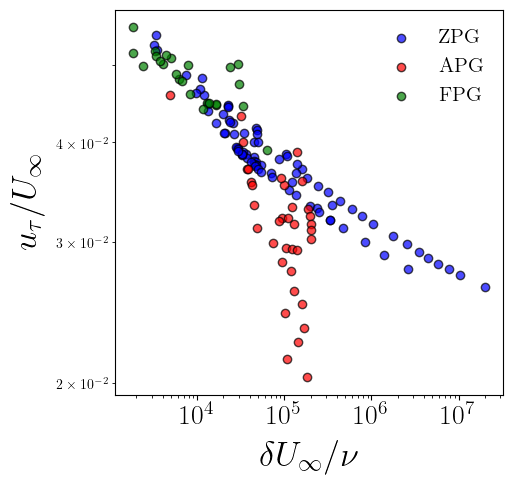

In [16]:
from matplotlib.ticker import ScalarFormatter
plt.figure(figsize=(5, 5))
plt.rcParams['font.family'] = 'Times New Roman'  # Set the font to Times New Roman
plt.rcParams['text.usetex'] = True  # Use LaTeX for all text rendering
nu    = X[:,1]
u_tau = Y
Re_0 = 1/nu

# Plot ZPG cases in blue
plt.scatter(Re_0[zpg_indices], u_tau[zpg_indices], alpha=0.7, edgecolors='k', color='blue', label="ZPG")

# Plot APG cases in red
plt.scatter(Re_0[apg_indices], u_tau[apg_indices], alpha=0.7, edgecolors='k', color='red', label="APG")

# Plot FPG cases in green
plt.scatter(Re_0[fpg_indices], u_tau[fpg_indices], alpha=0.7, edgecolors='k', color='green', label="FPG")
ax = plt.gca()
formatter = ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-2, -2))  # Force exponent at -2

ax.yaxis.set_major_formatter(formatter)
ax.ticklabel_format(style='scientific', axis='y', scilimits=(-2, -2))

# Hide the automatic offset and move 10^-2 to the label
ax.yaxis.get_offset_text().set_visible(False)  


# Customization of the plot
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(False)
plt.xlabel(r'${\delta U_{\infty}}/{\nu}$', fontsize=25, labelpad=8)
plt.ylabel(r'${u_{\tau}}/{U_{\infty}}$', fontsize=25, labelpad=8)
plt.legend(fontsize=15, loc='best',frameon=False)
plt.xscale('log')
plt.yscale('log')

# Save the plot
plt.savefig('Dixit_classical.pdf', dpi=300, bbox_inches='tight',transparent=True)

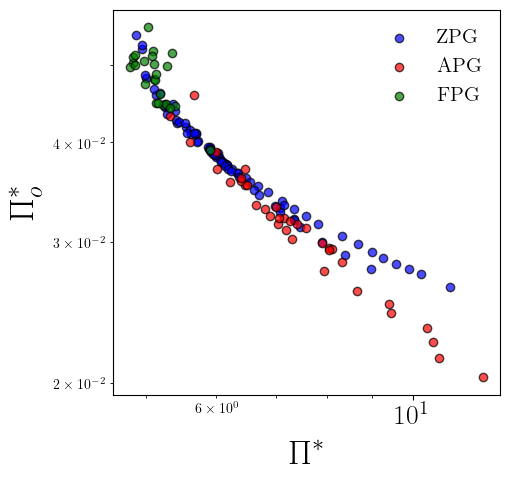

In [17]:
# input_frac = (U_inf*nu/M)**(4/9) * (U_inf*delta/nu)**(4/7)*(delta_star/theta)**(9/10)
# Plot with distinct colors for ZPG, FPG, and APG
plt.figure(figsize=(5, 5))
plt.rcParams['font.family'] = 'Times New Roman'
# Plot ZPG cases in blue
plt.scatter(input_PI[zpg_indices], Y[zpg_indices], alpha=0.7, edgecolors='k', color='blue', label="ZPG")
# Plot APG cases in red
plt.scatter(input_PI[apg_indices], Y[apg_indices], alpha=0.7, edgecolors='k', color='red', label="APG")
# Plot FPG cases in green
plt.scatter(input_PI[fpg_indices], Y[fpg_indices], alpha=0.7, edgecolors='k', color='green', label="FPG")
# Customization of the plot
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(False)
plt.xlabel(r'$\Pi^*$', fontsize=25, labelpad=8)
plt.ylabel(r'$\Pi_o^*$', fontsize=25, labelpad=8)
plt.legend(fontsize=15, loc='best',frameon=False)
plt.xscale('log')
plt.yscale('log')

# Save the plot
plt.savefig('Dixit_frac.pdf', dpi=300, bbox_inches='tight',transparent=True)

In [18]:
import pickle

workspace = {}
globals_copy = dict(globals())

for key, value in globals_copy.items():
    if not key.startswith('_') and not callable(value) and not hasattr(value, '__module__'):
        try:
            pickle.dumps(value)  # Test if it can be pickled
            workspace[key] = value
        except (TypeError, AttributeError):
            print(f"Skipping {key} - cannot pickle")

with open('output.pkl', 'wb') as f:
    pickle.dump(workspace, f)

Skipping np - cannot pickle
Skipping plt - cannot pickle
Skipping sys - cannot pickle
Skipping os - cannot pickle
Skipping IT_PI - cannot pickle
Skipping pickle - cannot pickle
Skipping globals_copy - cannot pickle
Skipping f - cannot pickle
